- ANTHONY SIAMPIRINGUE​
- IBRAHIM SOBH​
- ISAAC GONZALES​
- PATRICK SAADE​

In [ ]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

tfd = tfp.distributions

# Loding Dataset

In [70]:
# Loading diabetes dataset directly from sklearn.datasets
X, y = load_diabetes(return_X_y=True, as_frame=True)
diabetes = pd.concat((X, y), axis=1)

# Shuffle the diabetes dataset
diabetes = diabetes.sample(frac=1)

# X, y separation (for simplicity sake we only study one feature)
X = diabetes["bmi"].to_numpy().reshape(-1, 1)
y = diabetes["target"].to_numpy()

# Split the data
n = 200
X_train = X[:-n]
X_test = X[-n:]

# Split the targets
y_train = y[:-n]
y_test = y[-n:]



In [ ]:
#negative log-likelihood
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# Not Uncertainty

In [72]:
# create model with normal distribution
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])

In [73]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik)
model.fit(X_train, y_train, epochs=2000, verbose=False)

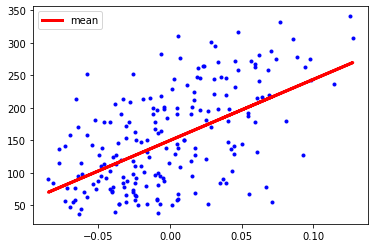

In [78]:
yhat_test = model(X_test)

plt.plot(X_test, y_test, 'b.');
plt.plot(X_test, yhat_test.mean(),'r', label='mean', linewidth=3);
plt.legend();

# Aleatoric Uncertainty

In [79]:
# create model to learn the 2 parameters of the normal distribution
# paramenters to learn: loc, mean, and scale, standard deviation. 
# because the standard deviation cannot be negative we use the softplus function
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:])))
])


In [80]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik)
model.fit(X_train, y_train, epochs=2000, verbose=False);

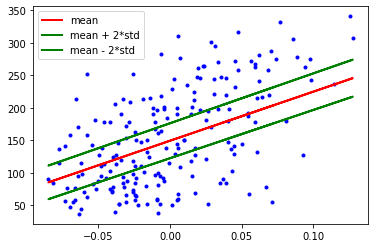

In [82]:
yhat_test = model(X_test)

plt.plot(X_test, y_test, 'b.');

m = yhat_test.mean()
s = yhat_test.stddev()

plt.plot(X_test, m, 'r', linewidth=2, label='mean');
plt.plot(X_test, m + 2 * s, 'g', linewidth=2, label=r'mean + 2*std');
plt.plot(X_test, m - 2 * s, 'g', linewidth=2, label=r'mean - 2*std');

plt.legend();

# Epistemic Uncertainty

In [104]:
# posterior
def posterior(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1))
  ])

In [120]:
# prior
def prior(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1))
  ])

In [122]:
# create model
# DenseVariational layer fits the weights posterior
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior, prior, kl_weight=1/X.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])


In [123]:
# inference
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik)
model.fit(X_train, y_train, epochs=2000, verbose=False);

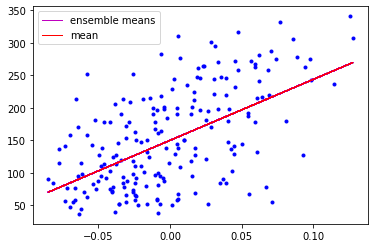

In [124]:
plt.plot(X_test, y_test, 'b.');
yhat_test_ = [model(X_test) for _ in range(200)]
avgm = np.zeros_like(X_test[..., 0])

for i, yhat in enumerate(yhat_test_):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  
  plt.plot(X_test, m, 'm', label='ensemble means' if i == 0 else None, linewidth=1);
  avgm += m
  
plt.plot(X_test, avgm/len(yhat_test_), 'r', label='mean', linewidth=1);

plt.legend();

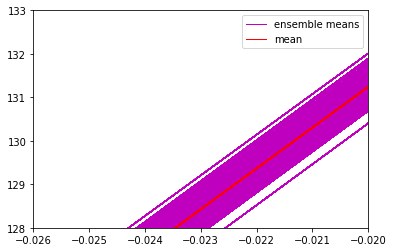

In [ ]:
avgm = np.zeros_like(X_test[..., 0])

for i, yhat in enumerate(yhat_test_):
    m = np.squeeze(yhat.mean())
    plt.plot(X_test, m, 'm', label='ensemble means' if i == 0 else None, linewidth=1)
    avgm += m

plt.plot(X_test, avgm/len(yhat_test_), 'r', label='mean', linewidth=1);

plt.ylim(128,133);
plt.xlim(-0.026, -0.02);

plt.legend();

# Aleatoric & Epistemic Uncertainty

In [ ]:
# create model that fits the weights posterior and the model posterior
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior, prior, kl_weight=1/X.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])))
])


In [118]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik)
model.fit(X_train, y_train, epochs=2000, verbose=False);

/home/isaac/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


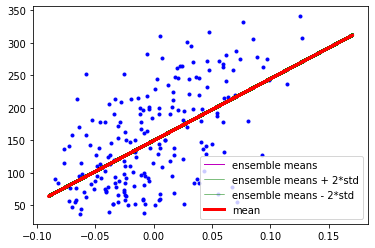

In [119]:
plt.plot(X_test, y_test, 'b.');

yhats = [model(X_train) for _ in range(200)]
avgm = np.zeros_like(X_train[..., 0])

for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())

  plt.plot(X_train, m, 'm', label='ensemble means' if i == 0 else None, linewidth=1.)
  plt.plot(X_train, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2*std' if i == 0 else None);
  plt.plot(X_train, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2*std' if i == 0 else None);
  avgm += m

plt.plot(X_train, avgm/len(yhats), 'r', label='mean', linewidth=3);
plt.legend();


/home/isaac/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


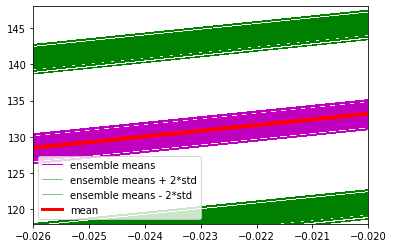

In [53]:
avgm = np.zeros_like(X_train[..., 0])

for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())

  plt.plot(X_train, m, 'm', label='ensemble means' if i == 0 else None, linewidth=1.)
  plt.plot(X_train, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2*std' if i == 0 else None);
  plt.plot(X_train, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2*std' if i == 0 else None);
  avgm += m

plt.ylim(118,148);
plt.xlim(-0.026, -0.02);
plt.plot(X_train, avgm/len(yhats), 'r', label='mean', linewidth=3);
plt.legend();